In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM
import matplotlib.pyplot as plt
import jax_dataclasses as jdc

In [2]:
BATCH_SIZE=5
new_motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=BATCH_SIZE,
    control_state=["torque"],
    static_params = {
                "p": 3,
                "r_s": 15e-3,
                "l_d": 0.37e-3,
                "l_q": 1.2e-3,
                "psi_p": 65.6e-3,
                "deadtime": 1,
            })


In [3]:
init_state = new_motor_env.init_state(new_motor_env.env_properties)

In [ ]:
PRNGKey = jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(BATCH_SIZE,)))
obs, motor_env_state = new_motor_env.vmap_reset(PRNGKey)
motor_env_state.physical_state

PMSM.PhysicalState(u_d_buffer=Array([0., 0., 0., 0., 0.], dtype=float32, weak_type=True), u_q_buffer=Array([0., 0., 0., 0., 0.], dtype=float32, weak_type=True), epsilon=Array([-2.8447292 , -0.19033496, -2.3770711 ,  1.1578462 , -2.5150537 ],      dtype=float32), i_d=Array([ -41.969044,  -81.90859 ,  -30.145252, -172.43398 , -207.87508 ],      dtype=float32), i_q=Array([ 217.65828 , -190.10614 ,  -50.518127,   93.176476, -108.40016 ],      dtype=float32), torque=Array([ 16.851213 , -19.676453 ,  -5.4675303,  20.874308 , -27.248142 ],      dtype=float32), omega_el=Array([ 465.1044 , 1725.0154 , 1555.7031 , 2514.8784 ,  562.96497],      dtype=float32))

In [4]:
obs, motor_env_state = new_motor_env.vmap_reset() #PRNGKey
next_state=motor_env_state
i_dqs=[]
for _ in range(1000):
    act=jnp.repeat(jnp.array([0.03,0.03])[:,None],BATCH_SIZE,axis=1).T
    obs_next,next_state=new_motor_env.vmap_step(next_state,act)
    i_dqs.append(obs_next[0,0:2])

Text(0, 0.5, 'i_q')

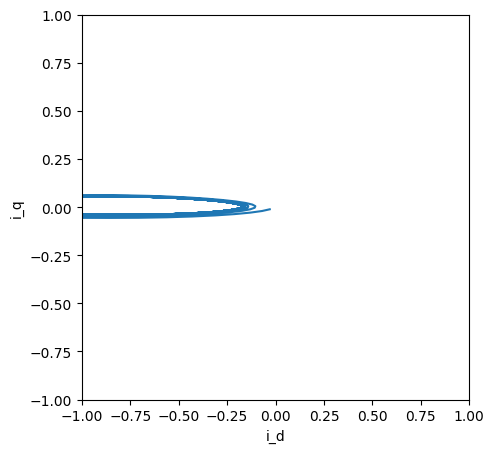

In [5]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()

### PMSM with GymWrapper

In [6]:
from exciting_environments import GymWrapper

In [7]:
BATCH_SIZE=5
new_motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=BATCH_SIZE,
    control_state=["torque"])
gym_pmsm= GymWrapper(env=new_motor_env)

No chosen control state in the GymWrapper. Control state is set to ['torque'].


In [8]:
gym_pmsm.reset()
i_dqs2=[]
for _ in range(1000):
    act=jnp.repeat(jnp.array([0.03,0.03])[:,None],BATCH_SIZE,axis=1).T
    obs_next,_,_,_=gym_pmsm.step(act)
    i_dqs2.append(obs_next[0,0:2])

Since no PRNGKey for reference was provided, reference generation is deactivated.


Text(0, 0.5, 'i_q')

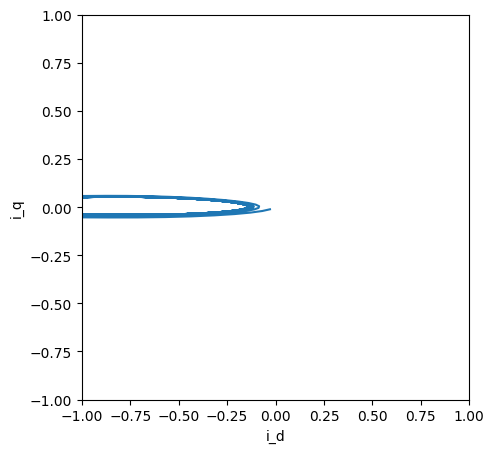

In [9]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs2)[:,0],jnp.array(i_dqs2)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()